# Look at Enron data set

## Loading data
I load the original data. The data is provided as a dcitionary. The keys are the names of the Enron employees.

In [1]:
import pickle
import numpy as np
data_dict = pickle.load(open("final_project_dataset.pkl", "r"))
names = data_dict.keys()
features = []
labels = [item["poi"] for item in data_dict.values()]
for item in data_dict.values():
    new_item = {}
    for key, value in item.items():
        if key=="poi": continue
        if value == "NaN":
            new_item[key] = np.nan
        else:
            new_item[key] = value
    features.append(new_item)
names

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HORTON STANLEY C',
 'PIPER GREGORY F',
 'HUMPHREY GENE E',
 'UMANOFF ADAM S',
 'BLACHMAN JEREMY M',
 'SUNDE MARTIN',
 'GIBBS DANA R',
 'LOWRY CHARLES P',
 'COLWELL WESLEY',
 'MULLER MARK S',
 'JACKSON CHARLENE R',
 'WESTFAHL RICHARD K',
 'WALTERS GARETH W',
 'WALLS JR ROBERT H',
 'KITCHEN LOUISE',
 'CHAN RONNIE',
 'BELFER ROBERT',
 'SHANKMAN JEFFREY A',
 'WODRASKA JOHN',
 'BERGSIEKER RICHARD P',
 'URQUHART JOHN A',
 'BIBI PHILIPPE A',
 'RIEKER PAULA H',
 'WHALEY DAVID A',
 'BECK SALLY W',
 'HAUG DAVID L',
 'ECHOLS JOHN B',
 'MENDELSOHN JOHN',
 'HICKERSON GARY J',
 'CLINE KENNETH W',
 'LEWIS RICHARD',
 'HAYES ROBERT E',
 'MCCARTY DANNY J',
 'KOPPER MICHAEL J',
 'LEFF DANIEL P',
 'LAVORATO JOHN J',
 'BERBERIAN DAVID',
 'DETMERING TIMOTHY J',
 'WAKEHAM JOHN',
 'POWERS WILLIAM',
 'GOLD JOSEPH',
 'BANNANTINE JAMES M',
 'DUNCAN JOHN H'

## Basic data features
Number of samples:

In [2]:
len(names)

146

Number of persons of interest (POIs):

In [3]:
sum(labels)

18

In [4]:
import pandas as pd
data = pd.DataFrame(features, index=names)
data["poi"]=labels
def get_count_miss_vals(data):
    colnames = []
    n_miss = []
    for col in data.columns:
        if data[col].dtype == np.float_:
            colnames.append(col)
            n_miss.append(sum(np.isnan(data[col])))
    df=pd.DataFrame(n_miss, index=colnames, columns=["n_missing"]).sort_values(by="n_missing", ascending=False)
    df["non_miss"]=len(data)-df["n_missing"]
    return df

get_count_miss_vals(data)

,n_missing,non_miss
loan_advances,142,4
director_fees,129,17
restricted_stock_deferred,128,18
deferral_payments,107,39
deferred_income,97,49
long_term_incentive,80,66
bonus,64,82
from_poi_to_this_person,60,86
from_this_person_to_poi,60,86
from_messages,60,86


In [5]:
def get_col_types(data):
    colnames = []
    coltypes = []
    for col in data.columns:
        colnames.append(col)
        coltypes.append(data[col].dtype)
    return pd.DataFrame(coltypes, index=colnames, columns=["coltypes"]).sort_values(by="coltypes", ascending=False)
get_col_types(data)

,coltypes
email_address,object
bonus,float64
long_term_incentive,float64
total_stock_value,float64
total_payments,float64
to_messages,float64
shared_receipt_with_poi,float64
salary,float64
restricted_stock_deferred,float64
restricted_stock,float64


In [6]:
def get_n_pois_for_miss_vals(data):
    colnames = []
    n_pois = []
    for col in data.columns:
        if data[col].dtype == np.float_:
            colnames.append(col)
            n_pois.append(sum(data["poi"][np.isnan(data[col])]))
    return pd.DataFrame(n_pois, index=colnames, columns=["n_pois"]).sort_values(by="n_pois", ascending=False)
get_n_pois_for_miss_vals(data)

,n_pois
restricted_stock_deferred,18
director_fees,18
loan_advances,17
deferral_payments,13
deferred_income,7
exercised_stock_options,6
long_term_incentive,6
to_messages,4
from_messages,4
from_poi_to_this_person,4


In [7]:
data[np.isnan(data["director_fees"])==False]["poi"]

CHAN RONNIE                False
BELFER ROBERT              False
URQUHART JOHN A            False
MENDELSOHN JOHN            False
WAKEHAM JOHN               False
POWERS WILLIAM             False
DUNCAN JOHN H              False
LEMAISTRE CHARLES          False
MEYER JEROME J             False
PEREIRA PAULO V. FERRAZ    False
BLAKE JR. NORMAN P         False
TOTAL                      False
JAEDICKE ROBERT            False
WINOKUR JR. HERBERT S      False
BHATNAGAR SANJAY           False
SAVAGE FRANK               False
GRAMM WENDY L              False
Name: poi, dtype: bool

To get a first look a t the data, I construct a 2 dimensional representation of the data using a technique called [t-stochastic neighbor embedding](https://lvdmaaten.github.io/tsne/). To be able to do this I have to convert the dictionaries to vectors.

In [8]:
from poi_id import SelectFeatureList
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import TSNE

tsne_viz = TSNE(n_components=2, random_state=42, perplexity=5, early_exaggeration=10).fit_transform(
    Imputer(strategy="median").fit_transform(
        DictVectorizer(sparse=False).fit_transform(
            SelectFeatureList(selected_feature_list=[
                'bonus',
                'deferral_payments',
                'deferred_income',
                'director_fees',
                #'email_address',
                'exercised_stock_options',
                'expenses',
                #'from_messages',
                #'from_poi_to_this_person',
                #'from_this_person_to_poi',
                'loan_advances',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'restricted_stock_deferred',
                'salary',
                #'shared_receipt_with_poi',
                #'to_messages',
                'total_payments',
                'total_stock_value'
            ]).fit_transform(features))))

In [9]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
output_notebook()

Loading BokehJS ...

In [10]:
from bokeh.palettes import RdBu3

names_Total = []
for name in names:
    if name=="TOTAL":
        names_Total.append(name)
    else:
        names_Total.append("")
source = ColumnDataSource(data=dict(x=tsne_viz[:,0],
                                    y=tsne_viz[:,1],
                                    names=names_Total,
                                    color=[RdBu3[label*2] for label in labels],
                                   ))
p = figure(plot_width=900, plot_height=500, active_scroll = "wheel_zoom")
p.circle(x="x", y="y", color="color", source=source, size=8)
plot_labels = LabelSet(x="x", y="y", text="names", source=source, level='glyph', render_mode='canvas')
p.add_layout(plot_labels)
show(p)

There are four obvious outliers: Andrew Fastow, Mark Koenig, Jamens Bannentine and Mitchell Taylor.

Now, I want to look at some features of the data set.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E76A198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000F073048>]], dtype=object)

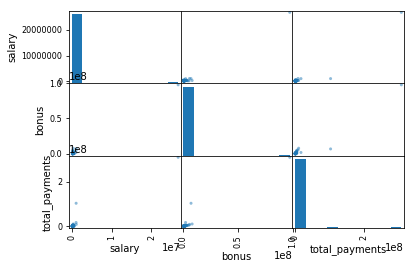

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
scatter_matrix(data[["salary", "bonus", "total_payments"]])

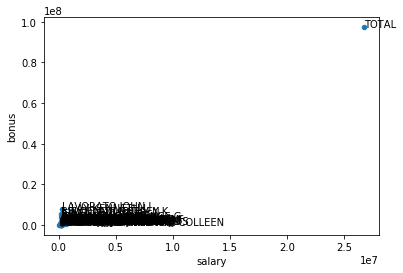

In [12]:
ax = data.plot.scatter(x="salary", y="bonus")
def label_point(data, x, y, ax):
    for i, point in data.iterrows():
        if np.isnan(point[x]) or np.isnan(point[y]): 
            continue
        else:
            #print "x, y", point[x], point[y]
            ax.text(point[x], point[y], i)
            
label_point(data, "salary", "bonus", ax)
plt.draw()

Obviously, there is a "TOTAL" entry in the data set. This is removed since it does not represent a real person.

In [13]:
#features.remove()
TOTAL_IDX = data.index.get_loc("TOTAL")
del features[TOTAL_IDX]
del names[TOTAL_IDX]
del labels[TOTAL_IDX]
data.drop("TOTAL", inplace=True)

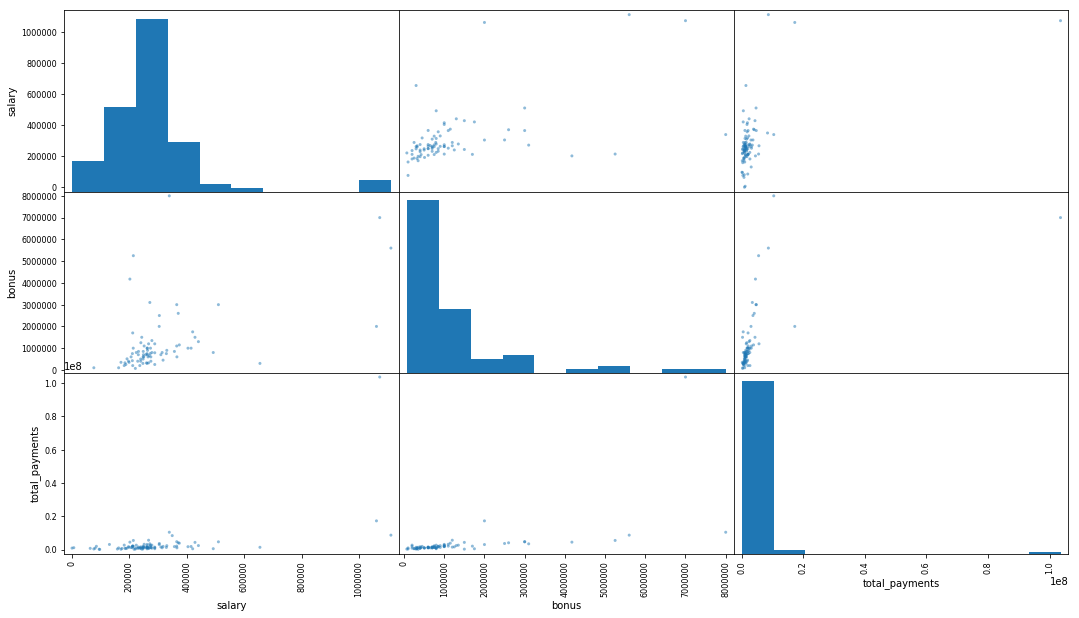

In [14]:
ax = scatter_matrix(data[["salary", "bonus", "total_payments"]], figsize=(18,10))

There is still an outlier in the total payments plot.

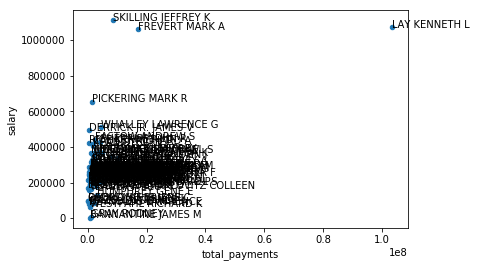

In [15]:
ax = data.plot.scatter(x="total_payments", y="salary")
label_point(data, "total_payments", "salary", ax)
plt.draw()

Since the outlier is a real person involved in the case I do not remove it.

###  Email features

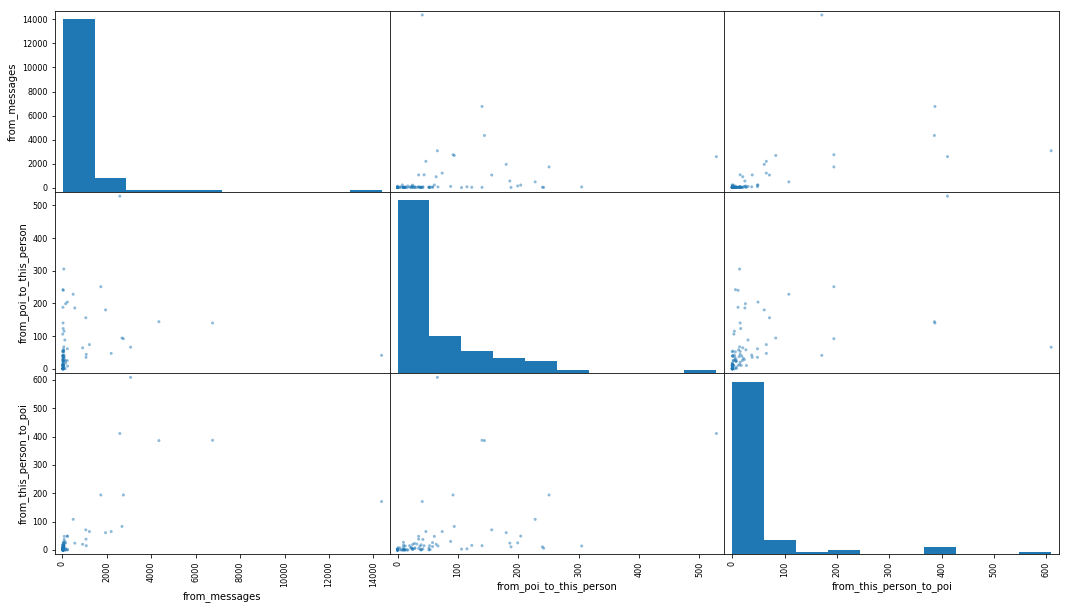

In [16]:
ax = scatter_matrix(data[["from_messages", "from_poi_to_this_person", "from_this_person_to_poi"]], figsize=(18,10))

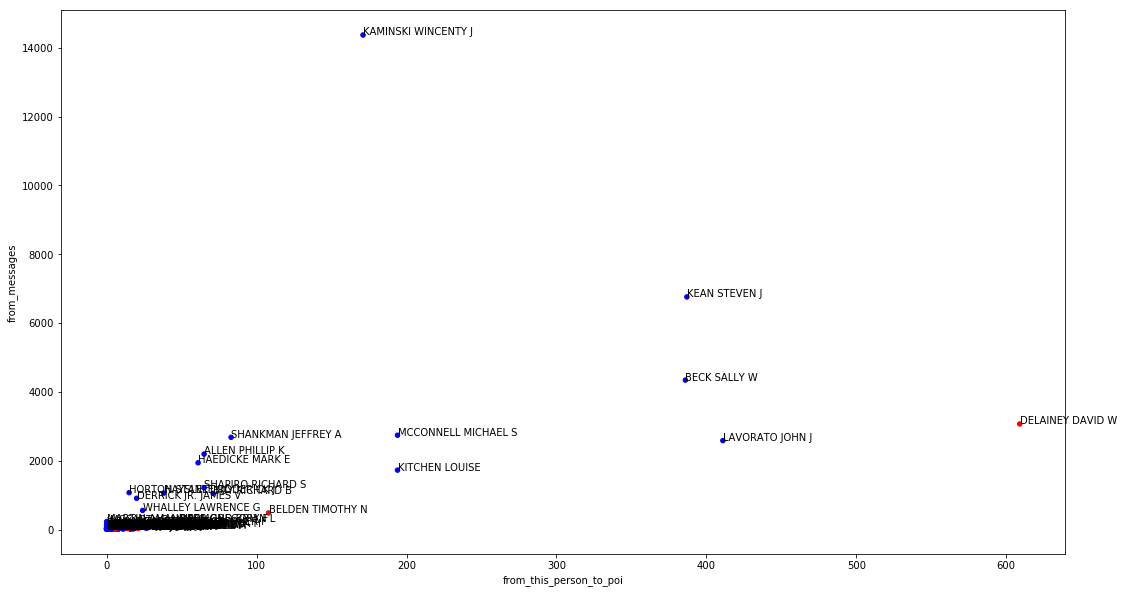

In [17]:
from matplotlib import cm
ax = data.plot.scatter(x="from_this_person_to_poi", y="from_messages", c=[("red" if poi==True else "blue") for poi in data["poi"]],
                       figsize=(18, 10))
label_point(data, "from_this_person_to_poi", "from_messages", ax)

In [18]:
data["ratio_from_to_poi_messages"]=data["from_this_person_to_poi"]/data["from_messages"]

df2 = data.groupby(['ratio_from_to_poi_messages', 'poi'])['ratio_from_to_poi_messages'].count().unstack('poi').fillna(0)
#plt.hist([data[data["poi"]==False]["ratio_from_to_poi_messages"],            data[data["poi"]==True]["ratio_from_to_poi_messages"]], stacked=True,histtype='bar')
[data[data["poi"]==False]["ratio_from_to_poi_messages"],
            data[data["poi"]==True]["ratio_from_to_poi_messages"]]
#['poi'].plot(kind='bar', stacked=True)
#ax = data[["ratio_from_to_poi_messages", "poi"]].plot.bar(stacked=True)
#label_point(data, "from_this_person_to_poi", "from_messages", ax)

[METTS MARK               0.034483
 BAXTER JOHN C                 NaN
 ELLIOTT STEVEN                NaN
 CORDES WILLIAM R         0.000000
 MORDAUNT KRISTINA M           NaN
 MEYER ROCKFORD G         0.000000
 MCMAHON JEFFREY          0.541667
 HORTON STANLEY C         0.013979
 PIPER GREGORY F          0.216216
 HUMPHREY GENE E          1.000000
 UMANOFF ADAM S           0.000000
 BLACHMAN JEREMY M        0.142857
 SUNDE MARTIN             0.342105
 GIBBS DANA R             0.000000
 LOWRY CHARLES P               NaN
 MULLER MARK S            0.000000
 JACKSON CHARLENE R       0.339286
 WESTFAHL RICHARD K            NaN
 WALTERS GARETH W              NaN
 WALLS JR ROBERT H        0.000000
 KITCHEN LOUISE           0.112269
 CHAN RONNIE                   NaN
 BELFER ROBERT                 NaN
 SHANKMAN JEFFREY A       0.030959
 WODRASKA JOHN                 NaN
 BERGSIEKER RICHARD P     0.000000
 URQUHART JOHN A               NaN
 BIBI PHILIPPE A          0.200000
 WHALEY DAVID A     

In [19]:
import poi_id
data_dict = poi_id.prepare_data(None, load=True)
labels = []
for key, value in data_dict.items():
    labels.append(value["poi"])

In [20]:
print data_dict[data_dict.keys()[0]].keys()[0:50]

[u'word_keith', u'word_barri', u'word_enjoy', u'word_delainey', u'word_buyer', u'word_obtain', u'word_recogn', u'sub_from_follow up', u'word_adjust', u'word_swap', u'sub_to_out of the office', u'sub_to_please note change midyear 2000 performance review process', u'word_contain', u'sub_to_2000 ena offsite', u'word_chair', u'sub_from_hiring practices for summer interns', u'word_profession', u'sub_from_cgas', u'word_conveni', u'word_chris', u'word_communicationsenron', u'word_infrastructur', u'word_construct', u'word_consult', u'sub_from_congrats', u'word_appli', u'word_vinc', u'sub_from_presentation', u'word_public', u'word_ultim', u'sub_to_enrononline executive summary for december 7 2000', u'sub_from_charts', u'word_act', u'word_encourag', u'sub_from_summer internship', u'word_molli', u'word_repli', u'word_measur', u'word_engin', u'sub_to_netco', u'word_candid', u'sub_from_returned mail user unknown', u'word_ed', u'word_attorney', u'word_texa', u'word_choic', 'exercised_stock_options',

In [21]:
features = []
labels = []
names = []
for key, value in data_dict.items():
    labels.append(value["poi"])
    #value.pop("poi",None)
    features.append(value)
    names.append(key)
    
tsne_viz = TSNE(n_components=2, random_state=42, perplexity=10, early_exaggeration=10).fit_transform(
    Imputer(strategy="median").fit_transform(
        DictVectorizer(sparse=False).fit_transform(features)))

In [22]:
source = ColumnDataSource(data=dict(x=tsne_viz[:,0],
                                    y=tsne_viz[:,1],
                                    names=names,
                                    color=[RdBu3[label*2] for label in labels],
                                   ))
p = figure(plot_width=900, plot_height=500, active_scroll = "wheel_zoom")
p.circle(x="x", y="y", color="color", source=source, size=8)
plot_labels = LabelSet(x="x", y="y", text="names", source=source, level='glyph', render_mode='canvas')
p.add_layout(plot_labels)
show(p)

### Selected features

In [25]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from poi_id import SelectMatchFeatures
pipeline_email = Pipeline([
    ("Selector", 
     SelectFeatureList(
         selected_feature_list=poi_id.FEATURES_EMAIL, convert_to_numeric=True)),
    ("ConvertToVector", DictVectorizer(sparse=False)),
    ("Imputer", Imputer(strategy="median")),
    ("Log1P", FunctionTransformer(func=lambda x: np.log1p(np.abs(x)))),
])
pipeline_subjects = Pipeline([
    ("GetEmailText", SelectMatchFeatures(feature_match="sub_.*")),
    ("SelectPercentile", SelectKBest(score_func=f_classif, k=10)),
])

# Combine email text features and other features
# then run classifier on these features
pipeline_union = Pipeline([
    ("union", FeatureUnion(
        transformer_list=[
            ("subjects", pipeline_subjects),
            ("email",pipeline_email),
        ]
    )),
        ("Scale", StandardScaler()),
])
features_transformed = pipeline_union.fit_transform(features, labels)
tsne_viz = TSNE(n_components=2, random_state=42, perplexity=10, early_exaggeration=10).fit_transform(features_transformed)

In [26]:
source = ColumnDataSource(data=dict(x=tsne_viz[:,0],
                                    y=tsne_viz[:,1],
                                    names=names,
                                    color=[RdBu3[label*2] for label in labels],
                                   ))
p = figure(plot_width=900, plot_height=500, active_scroll = "wheel_zoom")
p.circle(x="x", y="y", color="color", source=source, size=8)
plot_labels = LabelSet(x="x", y="y", text="names", source=source, level='glyph', render_mode='canvas')
p.add_layout(plot_labels)
show(p)

In [39]:
sub_features = pipeline_union.named_steps["union"].transformer_list[0][1].named_steps["GetEmailText"].get_feature_names()
select_sub_features_idx = pipeline_union.named_steps["union"].transformer_list[0][1].named_steps["SelectPercentile"].get_support(indices=True)
#.fit_transform(features, labels)
select_sub_features =  np.take(sub_features, select_sub_features_idx).tolist()

In [40]:
fin_features = pipeline_union.named_steps["union"].transformer_list[1][1].named_steps["ConvertToVector"].get_feature_names()
fin_features

['from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'to_messages']

In [41]:
data = pd.DataFrame(features_transformed, index=names, columns=select_sub_features + fin_features)
data

,sub_to_ene friday peer group report,sub_from_organizational announcement,sub_to_government affairs organizational changes,sub_to_policy committee review analystassociate program prc process,sub_to_executive committee meeting monday september 25,sub_to_executive committee meeting monday october 16 new sec rules,sub_to_la times article,sub_to_rac website portfolio tracking system,sub_to_advisory council presentations,sub_to_enron advisory council presentations,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages
METTS MARK,-0.219772,-0.243641,-0.538868,-0.355364,-0.516780,-0.534796,-0.305043,-0.439479,-0.317737,-0.534796,-0.576953,0.256396,-0.870740,0.165307,-0.272407
CORDES WILLIAM R,-0.219772,-0.243641,-0.538868,-0.355364,-0.516780,-0.534796,-0.305043,-0.439479,-0.317737,-0.534796,-1.054959,-0.504176,-1.270510,-1.358046,-0.318324
HANNON KEVIN P,-0.219772,5.079575,3.089788,3.775875,2.355666,2.280812,-0.305043,3.742971,4.529664,2.280812,-0.522473,0.156009,0.512237,0.403704,-0.055643
MEYER ROCKFORD G,-0.219772,-0.243641,-0.538868,-0.355364,-0.516780,-0.534796,-0.305043,-0.439479,-0.317737,-0.534796,-0.596332,-1.945136,-1.270510,-1.937210,-1.316509
MCMAHON JEFFREY,-0.219772,-0.243641,1.380992,-0.355364,1.002982,0.954894,-0.305043,1.773384,-0.317737,0.954894,-0.296510,0.505166,0.630352,0.874752,0.626131
HAEDICKE MARK E,-0.219772,1.120056,0.649181,-0.355364,-0.516780,-0.534796,-0.305043,-0.439479,-0.317737,-0.534796,1.806807,1.178780,1.109800,0.759509,1.072669
PIPER GREGORY F,-0.219772,-0.243641,-0.538868,-0.355364,-0.516780,-0.534796,-0.305043,-0.439479,-0.317737,-0.534796,0.569676,0.534970,0.974083,0.199330,0.086533
HUMPHREY GENE E,-0.219772,-0.243641,-0.538868,-0.355364,-0.516780,-0.534796,-0.305043,-0.439479,-0.317737,-0.534796,-0.868945,-0.504176,0.396501,-0.921569,-1.812921
BLACHMAN JEREMY M,-0.219772,-0.243641,3.142725,-0.355364,-0.516780,-0.534796,-0.305043,-0.439479,-0.317737,-0.534796,-0.973161,0.012742,-0.636890,0.901205,0.667843
SUNDE MARTIN,-0.219772,-0.243641,1.408454,-0.355364,-0.516780,-0.534796,-0.305043,-0.439479,-0.317737,-0.534796,-0.426984,0.240787,0.251557,0.961312,0.724233


In [45]:
from sklearn.decomposition import PCA
feature_decomp = PCA(n_components=2)
decomp_features = feature_decomp.fit_transform(features_transformed, labels)
pd.DataFrame(feature_decomp.components_, columns=select_sub_features + fin_features)

,sub_to_ene friday peer group report,sub_from_organizational announcement,sub_to_government affairs organizational changes,sub_to_policy committee review analystassociate program prc process,sub_to_executive committee meeting monday september 25,sub_to_executive committee meeting monday october 16 new sec rules,sub_to_la times article,sub_to_rac website portfolio tracking system,sub_to_advisory council presentations,sub_to_enron advisory council presentations,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages
0,0.075750,0.077034,0.244573,0.322934,0.317485,0.333526,0.061649,0.287501,0.310541,0.333526,0.151107,0.270451,0.249154,0.307038,0.256376
1,-0.081023,0.059238,0.019392,0.186808,0.298457,0.299973,-0.121964,0.111808,0.158591,0.299973,-0.385764,-0.326698,-0.357488,-0.318357,-0.385210


## Vectorize Email Text

In [ ]:
features = []
labels = []
names = []
for key, value in data_dict.items():
    labels.append(value["poi"])
    #value.pop("poi",None)
    features.append(value)
    names.append(key)
            
get_email_text = poi_id.SelectMatchFeatures(feature_match="^word_.*")
email_text = get_email_text.fit_transform(features)

print get_email_text.get_feature_names()[:10]

get_sub = poi_id.SelectMatchFeatures(feature_match="^sub_.*")
subs = get_sub.fit_transform(features)
print get_sub.get_feature_names()[:10]

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import numpy as np
selector = SelectKBest(k=10, score_func=f_classif)
selected_subs_vect = selector.fit_transform(subs, labels)
print sum(selector.get_support())
selected_subs = np.take(get_sub.get_feature_names(),selector.get_support(indices=True))
print selected_subs

In [ ]:
selected_subs_vect

In [ ]:
poi_id = reload(poi_id)

In [ ]:
import pandas as pd
df = pd.DataFrame(selected_subs_vect, index=zip(names, labels), columns=selected_subs)
#type(X.toarray())
df

In [ ]:
df_2 = pd.DataFrame(subs[:,:10], columns=get_sub.get_feature_names()[:10], index=names)
df_2

In [ ]:
#selector = SelectKBest(k=10, score_func=f_classif)
selected_word_vect = selector.fit_transform(email_text, labels)
selected_words = np.take(get_email_text.get_feature_names(),selector.get_support(indices=True))
print selected_words

In [ ]:
df_words = pd.DataFrame(selected_word_vect, index=names, columns=selected_words)
df_words

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
select_fin_feat = poi_id.SelectFeatureList(selected_feature_list=poi_id.FEATURES_FINANCIAL, convert_to_numeric=True)
dict_to_vect = DictVectorizer(sparse=False)
impute = Imputer(strategy="median")
impute.fit_transform(dict_to_vect.fit_transform(select_fin_feat.fit_transform(features)))
select_fin_feat.fit_transform(features)